In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
from collections import Counter
from wordcloud import WordCloud
from datetime import datetime
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from scipy.spatial.distance import cdist
import plotly.graph_objects as go
import folium
import pickle
warnings.filterwarnings('ignore')


[nltk_data] Downloading package stopwords to /Users/mansi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = pd.read_csv('AB_US_2020.csv')

In [3]:
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city
0,38585,Charming Victorian home - twin beds + breakfast,165529,Evelyne,NaN,28804,35.65146,-82.62792,Private room,60,1,138,16/02/20,1.14,1,0,Asheville
1,80905,French Chic Loft,427027,Celeste,NaN,28801,35.59779,-82.55540,Entire home/apt,470,1,114,07/09/20,1.03,11,288,Asheville
2,108061,Walk to stores/parks/downtown. Fenced yard/Pet...,320564,Lisa,NaN,28801,35.60670,-82.55563,Entire home/apt,75,30,89,30/11/19,0.81,2,298,Asheville
3,155305,Cottage! BonPaul + Sharky's Hostel,746673,BonPaul,NaN,28806,35.57864,-82.59578,Entire home/apt,90,1,267,22/09/20,2.39,5,0,Asheville
4,160594,Historic Grove Park,769252,Elizabeth,NaN,28801,35.61442,-82.54127,Private room,125,30,58,19/10/15,0.52,1,0,Asheville


In [4]:
data.shape

(226030, 17)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226030 entries, 0 to 226029
Data columns (total 17 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              226030 non-null  int64  
 1   name                            226002 non-null  object 
 2   host_id                         226030 non-null  int64  
 3   host_name                       225997 non-null  object 
 4   neighbourhood_group             110185 non-null  object 
 5   neighbourhood                   226030 non-null  object 
 6   latitude                        226030 non-null  float64
 7   longitude                       226030 non-null  float64
 8   room_type                       226030 non-null  object 
 9   price                           226030 non-null  int64  
 10  minimum_nights                  226030 non-null  int64  
 11  number_of_reviews               226030 non-null  int64  
 12  last_review     

In [6]:
# Dropping Duplicate Values
# You can choose any subset of features you want.
data = data.drop_duplicates(subset = ['host_id', 'host_name', 'latitude', 'longitude', 'room_type'])

In [7]:
data.isnull().sum()

id                                     0
name                                  28
host_id                                0
host_name                             33
neighbourhood_group               111799
neighbourhood                          0
latitude                               0
longitude                              0
room_type                              0
price                                  0
minimum_nights                         0
number_of_reviews                      0
last_review                        45862
reviews_per_month                  45862
calculated_host_listings_count         0
availability_365                       0
city                                   0
dtype: int64

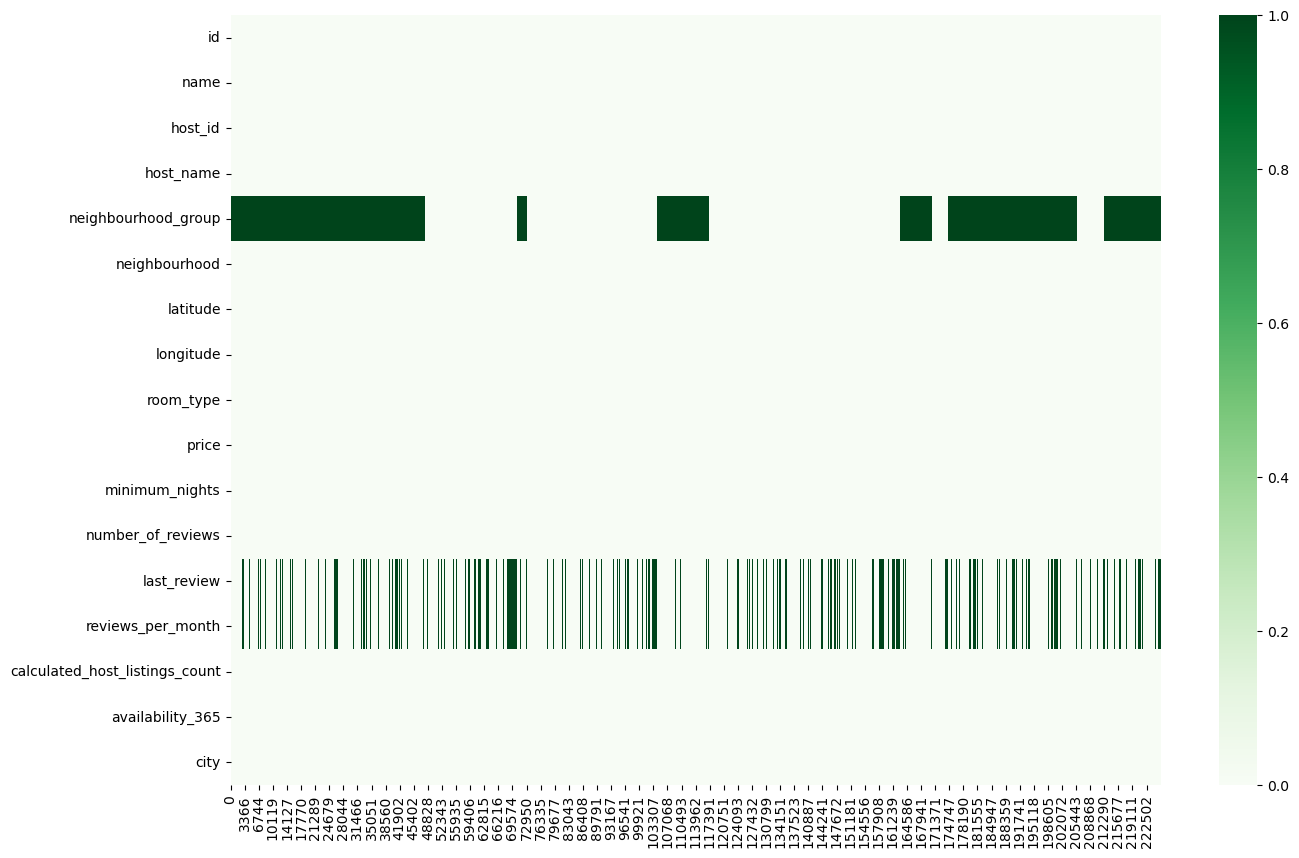

In [8]:
plt.figure(figsize = (15, 10))
sns.heatmap(data.isnull().T, cmap = 'Greens')
plt.show()

- There are many Null values in "neighbourhood_group" 
- The "last_review" and "reviews_per_month" shows presence of null values in similar pattern
- name and host_name have a few null values

## name column

In [9]:
data['log_price'] = np.log1p(data['price'])

In [10]:
# handling Null values in "name"
print("Null values before : ", data['name'].isnull().sum())
data['name'] = data['name'].fillna('NULL')
print("Null values after : ", data['name'].isnull().sum())

Null values before :  28
Null values after :  0


In [11]:
# Preprocessing Name feature
def preprocess_name(rows):
    sentence = str(rows).lower()
    sentence = re.sub('apt', 'apartment', sentence)
    sentence = re.sub('w/', 'with', sentence)
    sentence = re.sub('br', 'bedroom', sentence)
    sentence = re.sub('bedrms', 'bedroom', sentence)
    sentence = re.sub('blck', 'block', sentence)
    sentence = re.sub('univs', 'university', sentence)
    sentence = re.sub('&', 'and', sentence)
    sentence = re.sub('[+-\/|]', ' ', sentence)
    #sentence = re.sub('\s+', ' ',sentence)
    sentence = re.sub('\'', '', sentence)
    sentence = re.sub('‚òö', '', sentence)
    sentence = re.sub('[!#\"~*)(,.:;?]', ' ', sentence)
    sentence = "".join(re.findall('[a-zA-Z0-9\s]', sentence))
    sentence = re.sub('\s+', ' ',sentence)
    return sentence

data['preprocessed_name'] = data['name'].apply(preprocess_name)

In [12]:
# Deriving basic count based features from "name"
data['name_char_length'] = data['preprocessed_name'].apply(lambda x: len(x.strip()))
data['name_word_length'] = data['preprocessed_name'].apply(lambda x: len(x.split(' ')))

In [13]:
# lets see the distribution of words in name feature
name_words = []
english_stopwords = stopwords.words('english')
english_stopwords.append('')
for element in data['preprocessed_name'].values:
    name_words.extend(element.split(' '))

name_words = [word for word in name_words if word not in english_stopwords]

In [14]:
print("Total no of words : ", len(name_words))
print("Total unique words : ", len(set(name_words)))

Total no of words :  1222245
Total unique words :  33222


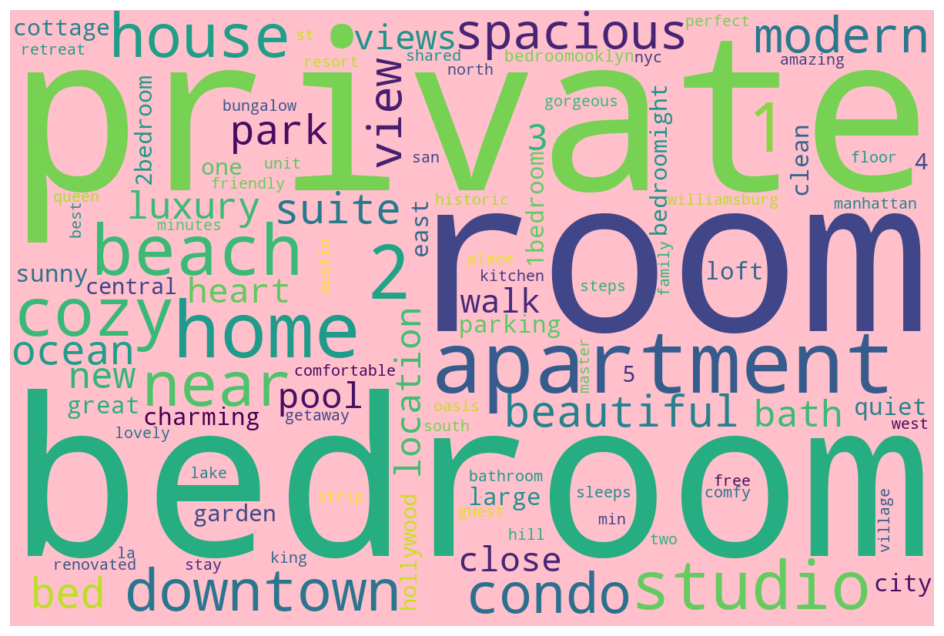

In [15]:
# WordCloud
name_reqs = {i[0] : i[1] for i in Counter(name_words).most_common(100)}
plt.figure(figsize = (16, 8))
wordcloud = WordCloud(width = 1200, height = 800, background_color = 'pink').generate_from_frequencies(name_reqs)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [16]:
data['log_name_char_length'] = np.log1p(data['name_char_length'])
data['log_name_word_length'] = np.log1p(data['name_word_length'])

In [17]:
# Filtering out the words which have occured more than 1000 times
# and calculating the amount of times they have appeared in the samples
count = CountVectorizer(stop_words = english_stopwords, min_df = 1000)
name_count_features = count.fit_transform(data['preprocessed_name'])

name_count_features = pd.DataFrame(name_count_features.toarray())
count_vocabs = {v : k for k,v in count.vocabulary_.items()}
name_count_features.columns = name_count_features.columns.map(count_vocabs)

In [18]:
name_count_features.sum(axis = 'rows').sort_values(ascending = False).head(10)

private      27061
bedroom      27031
room         26202
apartment    24568
home         19703
beach        15749
studio       14676
cozy         14656
near         12769
house        12223
dtype: int64

In [19]:
data['important_name_word_count'] = name_count_features.sum(axis = 'columns').values
data['not_important_name_word_count'] = data['name_word_length'] - data['important_name_word_count']

In [20]:
names = []
for sentence in data['preprocessed_name'].values:
    names.extend(sentence.split(' '))
    
names = [word for word in names if word not in english_stopwords]

In [21]:
# data.columns
temp_df = data[["preprocessed_name", "price", "log_price"]]

In [22]:
imp_words = [word[0] for word in Counter(names).most_common(30)]

In [23]:
for word in imp_words:
    temp_df[word] = temp_df['preprocessed_name'].apply(lambda x : 1 if word in x else 0)

In [24]:
words = dict()
words['word'] = []
words['mean_price'] = []
words['median_price'] = []

for word in imp_words:
    words['word'].append(word)
    words['mean_price'].append(temp_df[temp_df[word] == 1]['price'].mean())
    words['median_price'].append(temp_df[temp_df[word] == 1]['price'].median())

In [25]:
words = pd.DataFrame(words)

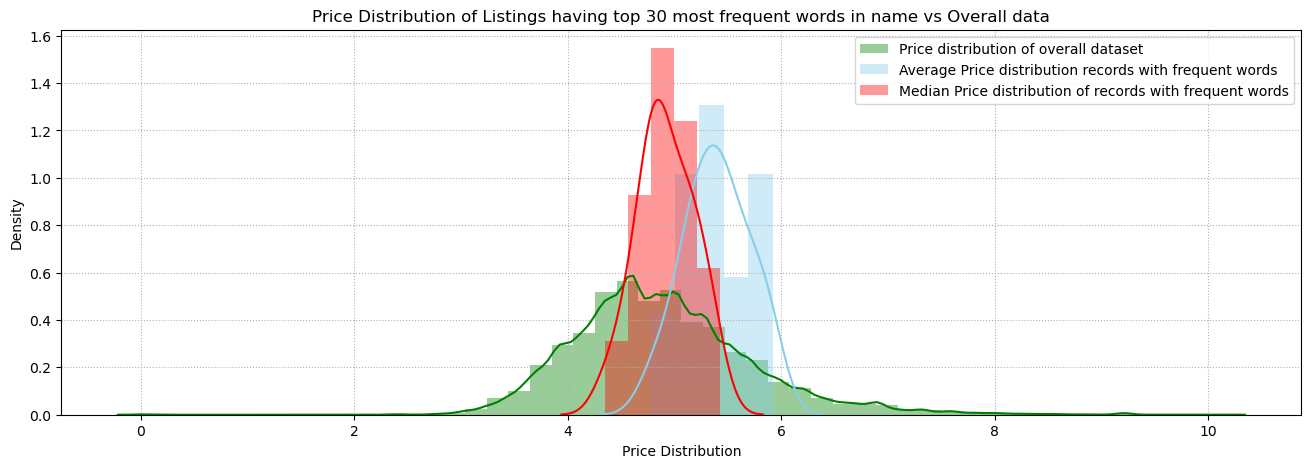

In [26]:
plt.figure(figsize = (16, 5))
sns.distplot(np.log1p(data['price']), label = "Price distribution of overall dataset", color='green')
sns.distplot(np.log1p(words['mean_price']), label = "Average Price distribution records with frequent words", color='skyblue')
sns.distplot(np.log1p(words['median_price']), label = "Median Price distribution of records with frequent words", color='red')
plt.legend()
plt.grid(linestyle = ":")
plt.xlabel("Price Distribution")
plt.title("Price Distribution of Listings having top 30 most frequent words in name vs Overall data")
plt.show()

In [27]:
del temp_df
del words

## neighbourhood_group column

In [28]:
neighbors = data[['neighbourhood_group', 'price']]

In [29]:
neighbors['neighbourhood_group'] = neighbors['neighbourhood_group'].fillna('Unknown')

In [30]:
nbrs = dict()
nbrs['neighbors'] = []
nbrs['mean_price'] = []

for n in neighbors['neighbourhood_group'].unique().tolist():
    nbrs['neighbors'].append(n)
    nbrs['mean_price'].append(neighbors[neighbors['neighbourhood_group'] == n]['price'].mean())

In [31]:
nbrs = pd.DataFrame(nbrs)
nbrs = nbrs.sort_values('mean_price', ascending = False).reset_index(drop = True)

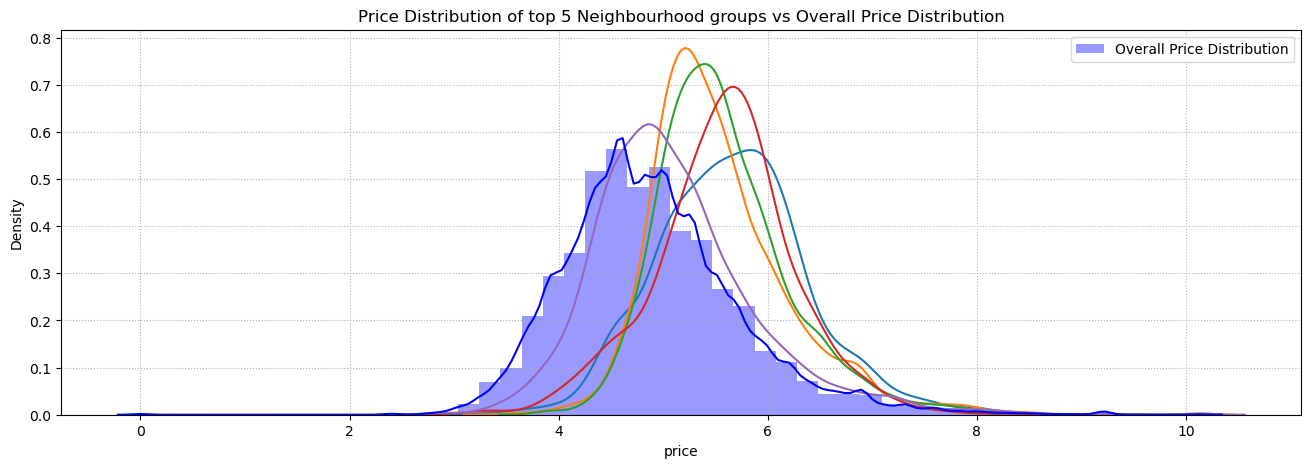

In [32]:
plt.figure(figsize = (16, 5))
for nbr in nbrs['neighbors'].values.tolist()[:5]:
    sns.distplot(np.log1p(data[data['neighbourhood_group'] == nbr]['price']), hist = False)
sns.distplot(np.log1p(data['price']), label = "Overall Price Distribution", color = 'blue')
plt.legend()
plt.grid(linestyle = ":")
plt.title("Price Distribution of top 5 Neighbourhood groups vs Overall Price Distribution")
plt.show()

In [33]:
del neighbors
del nbrs

## neighbourhood column

In [34]:
numbers = []
for v in data['neighbourhood'].values:
    try:
        numbers.append(int(v))
    except:
        pass
    
numbers = [str(e) for e in numbers]

In [35]:
areas = []
for element in data['neighbourhood'].values:
    areas.extend(element.split(' '))
    
areas = [e for e in areas if e not in numbers]

In [36]:
temp_df = data[['neighbourhood', 'price']]

In [37]:
imp_areas = [word[0] for word in Counter(areas).most_common(30)]

In [38]:
for area in imp_areas:
    temp_df[area] = temp_df['neighbourhood'].apply(lambda x : 1 if area in x else 0)

In [39]:
areas = dict()
areas['area'] = []
areas['mean_price'] = []
areas['median_price'] = []

for area in imp_areas:
    areas['area'].append(area)
    areas['mean_price'].append(temp_df[temp_df[area] == 1]['price'].mean())
    areas['median_price'].append(temp_df[temp_df[area] == 1]['price'].median())

In [40]:
areas = pd.DataFrame(areas)

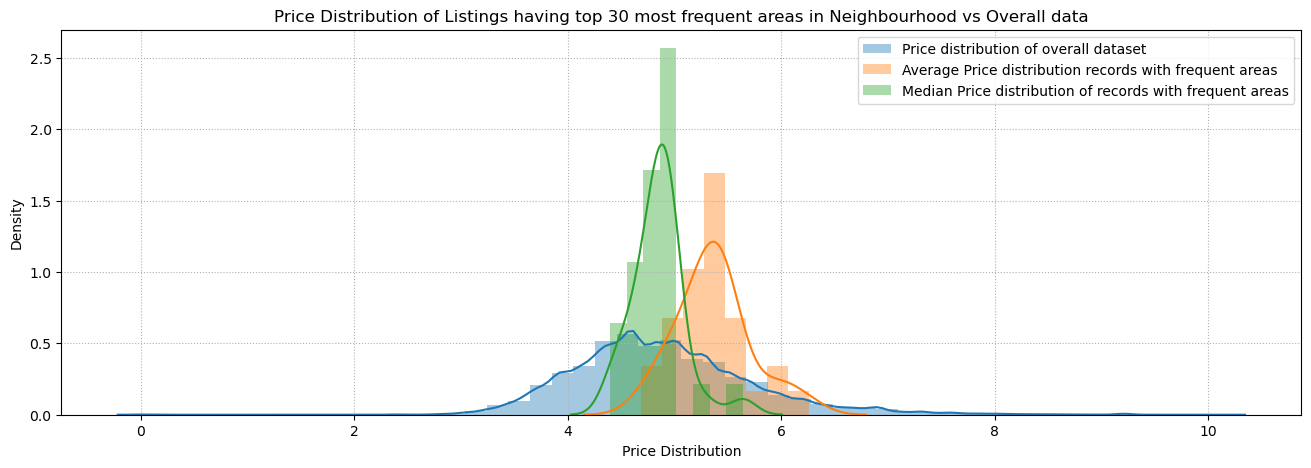

In [41]:
plt.figure(figsize = (16, 5))
sns.distplot(np.log1p(data['price']), label = "Price distribution of overall dataset")
sns.distplot(np.log1p(areas['mean_price']), label = "Average Price distribution records with frequent areas")
sns.distplot(np.log1p(areas['median_price']), label = "Median Price distribution of records with frequent areas")
plt.legend()
plt.grid(linestyle = ":")
plt.xlabel("Price Distribution")
plt.title("Price Distribution of Listings having top 30 most frequent areas in Neighbourhood vs Overall data")
plt.show()

In [42]:
del temp_df
del areas

## name and neighbourhood columns

In [43]:
temp_df = data[['name', 'neighbourhood', 'price']]

In [44]:
def return_words(rows):
    words_found = []
    for word in imp_words:
        if word in rows:
            words_found.append(word)
        else:
            pass
    words_found.sort()
    #wf = " ".join(words_found)
    #wf = re.sub("\s+", " ", wf)
    return len(words_found)

temp_df['imp_words'] = temp_df['name'].apply(return_words)


def return_areas(rows):
    areas_found = []
    for area in imp_areas:
        if area in rows:
            areas_found.append(area)
        else:
            pass
    areas_found.sort()
    #af = " ".join(areas_found)
    #af = re.sub("\s+", " ", af)
    return len(areas_found)

temp_df['imp_areas'] = temp_df['neighbourhood'].apply(return_areas)

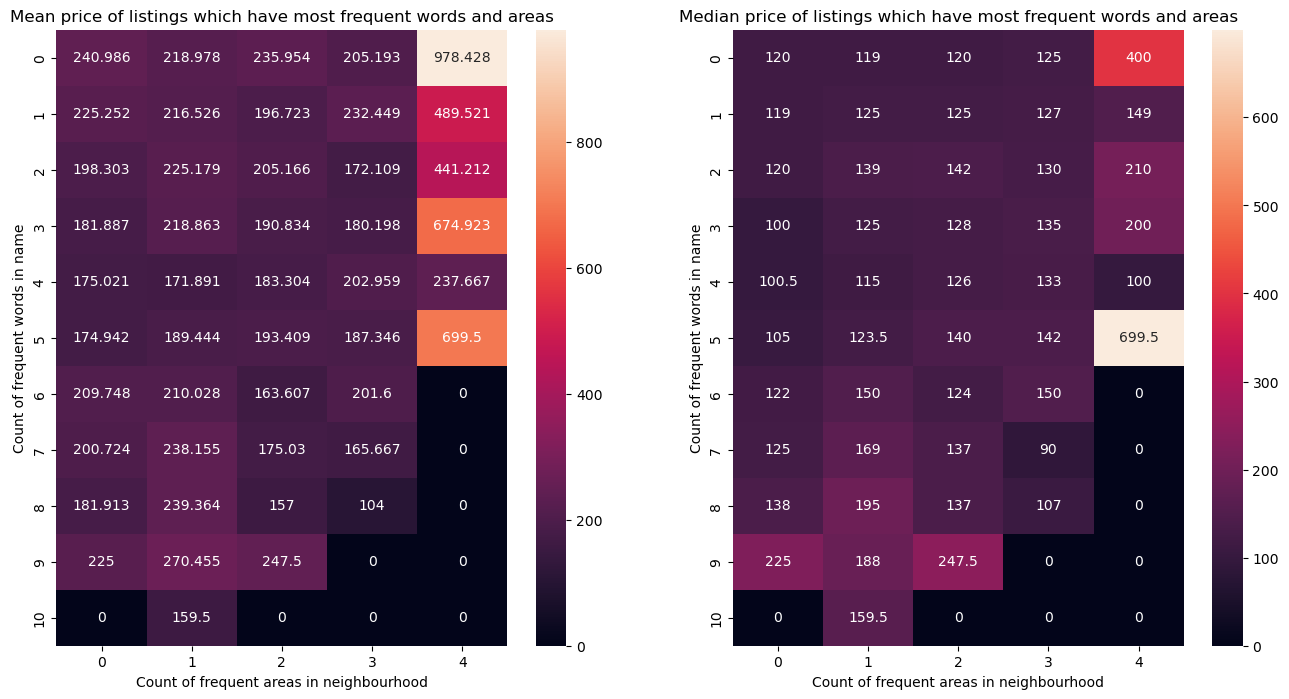

In [45]:
mean_intersection = pd.pivot_table(data = temp_df, 
                                   index = temp_df['imp_words'], 
                                   columns = temp_df['imp_areas'], 
                                   fill_value = 0, 
                                   aggfunc = np.mean)

median_intersection = pd.pivot_table(data = temp_df, 
                                   index = temp_df['imp_words'], 
                                   columns = temp_df['imp_areas'],
                                   fill_value = 0, 
                                   aggfunc = np.median)

fig = plt.figure(figsize = (16, 8))

fig.add_subplot(1,2,1)
sns.heatmap(mean_intersection, annot = True, fmt = 'g')
plt.xticks(ticks = [0.5, 1.5, 2.5, 3.5, 4.5], labels = ['0', '1', '2', '3', '4'])
plt.ylabel("Count of frequent words in name")
plt.xlabel("Count of frequent areas in neighbourhood")
plt.title("Mean price of listings which have most frequent words and areas")

fig.add_subplot(1,2,2)
sns.heatmap(median_intersection, annot = True, fmt = 'g')
plt.xticks(ticks = [0.5, 1.5, 2.5, 3.5, 4.5], labels = ['0', '1', '2', '3', '4'])
plt.ylabel("Count of frequent words in name")
plt.xlabel("Count of frequent areas in neighbourhood")
plt.title("Median price of listings which have most frequent words and areas")

plt.show()

- From the above heatmap we can assume that a better neighbourhood goes for a better price than from having a flashy name
- The prices are highest around places which have 4 most frequent occuring places in the neighbourhood

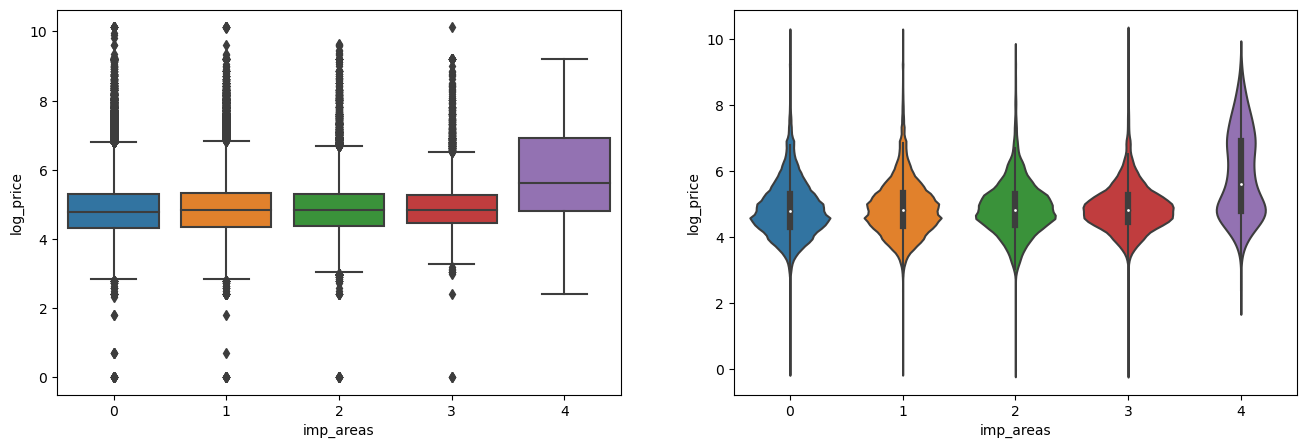

In [46]:
# price distribution of listings belonging to famous neighbourhoods
temp_df['log_price'] = np.log1p(temp_df['price'])

fig = plt.figure(figsize = (16, 5))

fig.add_subplot(1,2,1)
sns.boxplot(x = 'imp_areas', y = 'log_price', data = temp_df)

fig.add_subplot(1,2,2)
sns.violinplot(x = 'imp_areas', y = 'log_price', data = temp_df)

plt.show()

## minimum_nights column

In [47]:
# Lets see how city affects the price of listings

In [48]:
temp_df = data[['neighbourhood', 'room_type', 'city', 'price']]

In [49]:
# Price distribution among the cities in Overall Dataset
city = temp_df.groupby('city')['price'].agg(['mean', 'median', 'std'])

In [50]:
temp_df['imp_areas'] = temp_df['neighbourhood'].apply(return_areas)

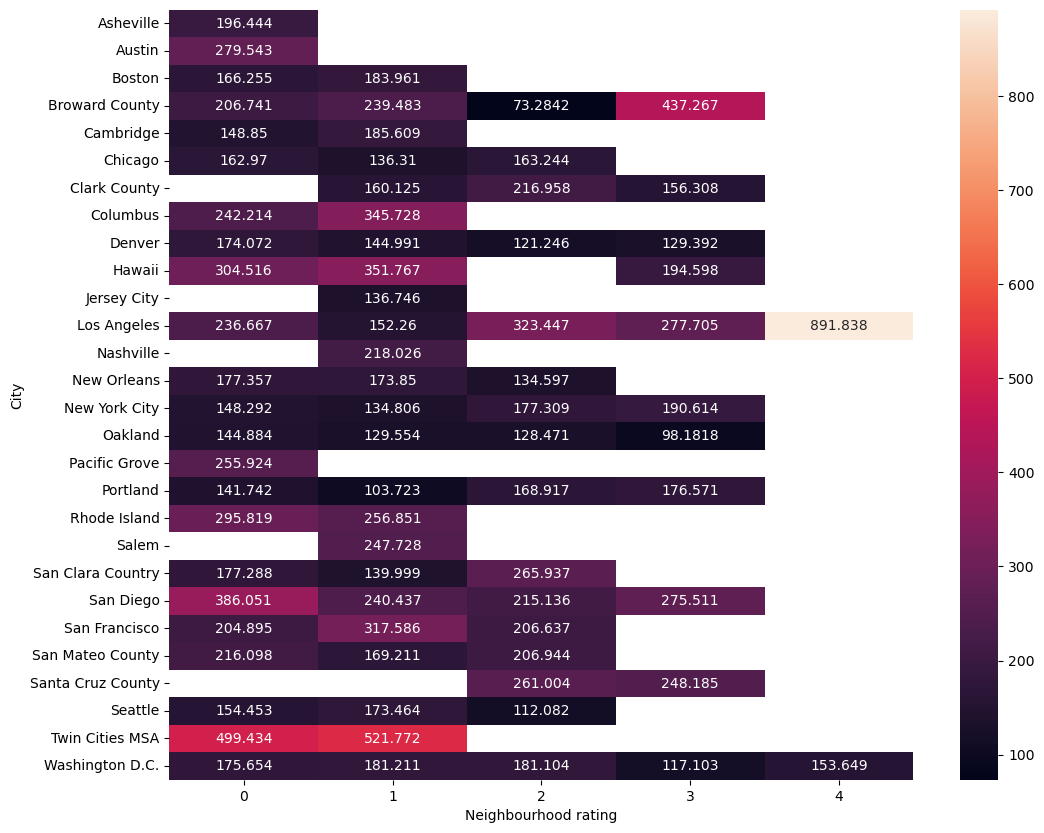

In [51]:
pivot = pd.pivot_table(data = temp_df, index = temp_df['city'], columns = temp_df['imp_areas'], aggfunc = np.mean)
plt.figure(figsize = (12, 10))
sns.heatmap(pivot, annot = True, fmt = 'g')
plt.xticks(ticks = [0.5, 1.5, 2.5, 3.5, 4.5], labels = [0, 1, 2, 3, 4])
plt.xlabel("Neighbourhood rating")
plt.ylabel("City")
plt.show()

- Los Angeles with the best neighbourhood rating has the highest average pricing among all the listings